This jupyter notebook provides an example of how to run an equillibrium simulation of the ZEMBA model. 

# Conda Environment

Ensure you have a conda environment which has NUMBA installed. 

Either:

(1) Follow the instructions to create a conda environment for ZEMBA at the github repository: https://github.com/daniel-francis-james-gunning/zemba_v01.git

(2) Simply install NUMBA to your current conda environment: conda install -c conda-forge numba

# Model Set-Up

Put simply, all model data is stored in python dictionaries, which are run through functions to simulate the exchanges of energy within the ZEMBA energy balance model. Below provides a brief description of the main ZEMBA dictionaties and functions of interest...

### Model Dictionaries:

**Var**: A python dictionary containing model constants for ***ZEMBA*** (e.g. heat capacities, melting points, model grid, etc.).

**INPUT**: A python dictionary containing all input variables for ***ZEMBA*** such as land fractions, land elevation, fractional ice coverage over land, fractional cloud cover and other key model inputs (e.g. CO2 concentration, albedo of ground/ice/snow, diffusion coefficients for atmospheric and ocean heat transport etc.).

**settings**: A python dictionary for determining ***ZEMBA*** settings. Used for turning model features on or off (e.g. sea-ice, meridional heat transport, hydrological cycle etc.) 

**State**: A python dictionary containing the current model state for a given day (including temperatures, humidities, precipitation, radiative fluxes, turbulent heat fluxes, meridional heat fluxes etc.)

**StateYear**: A python dictionary containing the model state saved for the last year of the simulation (including temperatures, humidities, precipitation, radiative fluxes, turbulent heat fluxes, meridional heat fluxes etc.)

**StateAnnual**: A python dictionary containing saved variables for every year of the simulation.

### Model Functions:

<span style="color:blue"> *Var = get_constants(input_zemba):*       

    Returns ZEMBA model constants...

<span style="color:blue"> *State = initialize_state(Var, input_zemba)*: 

    Returns an initialized **ZEMBA** model state...
    
    
<span style="color:blue"> *ecc, obl, pre, I, znth_sw, znth_dw = calculate_daily_insolation(orb, Var["latr"], Var["ndays"], day_type = 1) 

    Returns a seasonal cycle in insolation forcing (I) and solar zenith angles (znth_sw: solar-weighted, znth_dw: daytime mean weighted). Input includes a python dictionary 'orb' containing the orbital parameters, the latitude grid spacing in radians (Var['latr']) and for which days (Var["ndays"])
    

<span style="color:blue"> *State, StateYear, StateAnnual = ebm(Var, State, input_zemba, I, znth_dw, settings_zemba)*

    The main ZEMBA model function... 






# The INPUT file

The input file loads the *INPUT* and *settings* dictionaries, which specificy the ZEMBA model settings and the model input parameters. 

In the input folder of the ZEMBA repository, there are a number of input files pertaining to different equillibrium simulations.

Below I have loaded a template for an input file. Arrows highlight sections of code that can be changed (or replaced) depending on your choice of model run.


In [1]:
import os
script_path = os.getcwd()
input_path = script_path + '/input'
output_path = script_path + '/output'
os.chdir(input_path)

In [2]:
# %load input_template.py
"""
@author: Daniel Gunning (University of Bergen)

Example template for constructing an input file for an equillibrium run of ZEMBA. 
Settings are kept to the standard pre-industrial run for the moist EBM version of ZEMBA.

<-----------------------------HERE = parameters/settings that can be changed

<-----------------------------COMMENT/UNCOMMENT = sections that can be commented/uncommented for different settings 
"""

import numpy as np
from numba.core import types
from numba.typed import Dict
from numba import njit
import xarray as xr
import os
import pandas as pd
import pickle

# NAME OF RUN.
name = 'template'

# PATH
path = os.getcwd()   # MIGHT NEED TO CHANGE PATHS TO ACCESS *OTHER DATA* FOLDER

#--------------
# MODEL VERSION  <-------------------------------------------------------------------------------COMMENT/UNCOMMENT
#--------------

input_version = 'moist'  # moist EBM

# input_version = 'dry'    # dry 'classic' EBM

#------------
# Model prior  <-------------------------------------------------------------------------------COMMENT/UNCOMMENT
#------------

# prior = 'PI'  # initalize with pre-industrial run...

# prior = 'LGM' # initalize with last-glacial maximum run...

prior = None    # intialize with arbitrary state...

#---------------
# Model settings [e.g. for turning processes/feedbacks on or off.]
#---------------

settings_zemba = Dict.empty(key_type=types.unicode_type, value_type=types.int8[:])

# snowfall [ 0 = OFF, 1 = ON (uniform coverage), 2 = ON (fractional coverage) ]
settings_zemba["snow"]=np.array([2], dtype = "int8") # <---------------------------------------- HERE
if input_version == 'dry':
    settings_zemba["snow"][0] = 0
    
# hydrological cycle [ 0 = OFF , 1 = ON ]
settings_zemba["hydro"]=np.array([1], dtype = "int8")  # <-------------------------------------- HERE
if input_version == 'dry':
    settings_zemba["hydro"][0] = 0 
    
# sea ice [ 0 = OFF , 1 = ON ]
settings_zemba["seaice"]=np.array([1], dtype = "int8") # <-------------------------------------- HERE

# meridional heat transport [ 0 = OFF , 1 = ON ]
settings_zemba["transport"]=np.array([1], dtype = "int8") # <----------------------------------- HERE

# hadley cell parameterization [ 0 = OFF , 1 = ON ]
settings_zemba["hadley_cell"]=np.array([1], dtype = "int8") # <--------------------------------- HERE

# atmospheric heat transport [ 0 = OFF , 1 = ON ]
settings_zemba["atm_transport"]=np.array([1], dtype = "int8") # <------------------------------- HERE

# ocean heat transport [ 0 = OFF , 1 = ON]
settings_zemba["ocn_transport"]=np.array([1], dtype = "int8") # <------------------------------- HERE

# influence of height [ 0 = OFF , 1 = ON]
settings_zemba["height"]=np.array([0], dtype = "int8")        # <------------------------------- HERE

# model version [ 0 = classic 'dry', 1 = moist]
if input_version == 'moist':
    settings_zemba['version'] = np.array([1], dtype = "int8")
if input_version == 'dry':
    settings_zemba['version'] = np.array([0], dtype = "int8")
if input_version != 'moist' and input_version != 'dry':
    raise Exception("Model version must be either: 'moist' or 'dry'")

#------------
# Model input 
#------------

input_zemba = Dict.empty(key_type=types.unicode_type, value_type=types.float64[:])

# set-up
#-------

input_zemba['nyrs']=np.array([3000.]) # no. of model years...            # <-------------------- HERE
input_zemba['occ']=np.array([-5.])    # mid-point of ocean circulation...# <-------------------- HERE
input_zemba['ikyr']=np.array([0.])    # kyr BP for orbital parameters    # <-------------------- HERE

# Resolution [in degrees of latitude]
#-----------

input_zemba['res']=np.array([5.0])  # <-------------------------------------------------------- HERE

if input_zemba['res'][0] == 5.:  # if 5 degree
    lat   = np.arange(-87.5, 87.5+5., 5.)
    latb  = np.arange(-90, 90+5., 5.)
    olat  = np.arange(-67.5, 77.5+5., 5.)
    olatb = np.arange(-70, 80+5., 5.)
    
if input_zemba['res'][0] == 2.5:   # if 2.5 degree
    lat   = np.arange(-88.75, 88.75+2.5, 2.5)
    latb  = np.arange(-90, 90+2.5, 2.5)
    olat  = np.arange(-68.75, 78.75+2.5, 2.5)
    olatb = np.arange(-70, 80+2.5, 2.5)
    
if input_zemba['res'][0] == 1.:    # if 1. degree
    lat = np.arange(-89.5, 89.5+1., 1.)
    latb = np.arange(-90, 90+1., 1.)
    olat = np.arange(-69.5, 79.5+1., 1.)
    olatb = np.arange(-70, 80+1., 1.)
    
if input_zemba['res'][0] != 5. and input_zemba['res'][0] != 2.5 and input_zemba['res'][0] != 1.:
    raise Exception("Sorry, the choices of model resolution are 1, 2.5 and 5")
        

# [option to modify strength of overturning, e.g. 1.03 is 3% increase]
#---------------------------------------------------------------------

input_zemba['strength_of_overturning']=np.array([1.]) # <------------------------------------------ HERE

# [option to modify strength of insolation]
#------------------------------------------

input_zemba['strength_of_insolation']=np.array([1.])  # <------------------------------------------ HERE

# [option to keep snow over land fixed to the pre-industrial.]  <---------------------------------- COMMENT/UNCOMMENT
#-------------------------------------------------------------

settings_zemba['fixed_snow'] = np.array([0], dtype = "int8") #--> OFF.
fixed_snow_fraction = None
fixed_snow_thick    = None
fixed_snow_melt     = None

# settings_zemba['fixed_snow'] = np.array([1], dtype = "int8") #--> ON.
# with open(path+'/output/equilibrium/pi_moist_res5.0.pkl', 'rb') as f:
#     pi = pickle.load(f)['StateYear']
# fixed_snow_fraction = pi['snow_fraction_land']
# fixed_snow_thick    = pi['snow_thick']             
# fixed_snow_melt     = pi['melt']


# [option to keep sea ice fixed to the pre-industrial.]  <----------------------------------------- COMMENT/UNCOMMENT
#------------------------------------------------------

settings_zemba['fixed_seaice'] = np.array([0], dtype = "int8") #--> OFF.
fixed_si_fraction = None
fixed_si_thick = None
fixed_si_melt = None

# settings_zemba['fixed_seaice'] = np.array([1], dtype = "int8") #--> ON.
# with open(path+'/output/equilibrium/pi_moist_res5.0.pkl', 'rb') as f:
#     pi = pickle.load(f)['StateYear']
# fixed_si_fraction = pi['si_fraction'] 
# fixed_si_thick    = pi['si_thick']       
# fixed_si_melt     = pi['si_melt_flux']    
    
# [option to keep land albedo fixed to the pre-industrial.]   <----------------------------------- COMMENT/UNCOMMENT
#----------------------------------------------------------

settings_zemba['fixed_land_albedo'] = np.array([0], dtype = "int8") #--> OFF.
fixed_land_albedo = None 

# settings_zemba['fixed_land_albedo'] = np.array([1], dtype = "int8") #--> ON.
# with open(path+'/output/equilibrium/pi_moist_res5.0.pkl', 'rb') as f:
#     pi = pickle.load(f)['StateYear']
# fixed_land_albedo = pi['alpha_land']
    

# [option to keep ocean albedo fixed to the pre-industrial.]  <----------------------------------- COMMENT/UNCOMMENT
#-----------------------------------------------------------

settings_zemba['fixed_ocean_albedo'] = np.array([0], dtype = "int8") #--> OFF.
fixed_ocean_albedo = None

# settings_zemba['fixed_ocean_albedo'] = np.array([1], dtype = "int8") #--> ON.
# with open(path+'/output/equilibrium/pi_moist_res5.0.pkl', 'rb') as f:
#     pi = pickle.load(f)['StateYear']
# fixed_ocean_albedo = pi['alpha_ocean'] 
    

# Land fractions <----------------------------------------------------------------------------------COMMENT/UNCOMMENT
#---------------

# Present-day from ICE6G_C dataset (Argus et al., 2014; Peltier et al., 2014)
ice6g_lat = pd.read_csv(path+'/other_data/ice6g/ice6g.txt', skiprows=7, usecols=[0], sep='\t').to_numpy()[:,0]
ice6g_lf  = pd.read_csv(path+'/other_data/ice6g/ice6g.txt', skiprows=7, usecols=[1], sep='\t').to_numpy()[:,0]
input_zemba['land_fraction'] = np.interp(lat, ice6g_lat, ice6g_lf)

# LGM from ICE6G_C dataset (Argus et al., 2014; Peltier et al., 2014)
# ice6g_lat = pd.read_csv(path+'/other_data/ice6g/ice6g.txt', skiprows=7, usecols=[0], sep='\t').to_numpy()[:,0]
# ice6g_lf  = pd.read_csv(path+'/other_data/ice6g/ice6g.txt', skiprows=7, usecols=[2], sep='\t').to_numpy()[:,0]
# input_zemba['land_fraction'] = np.interp(lat, ice6g_lat, ice6g_lf)

#|
#|-> Ensure Antarctic continent occupies entire area south of 75S
if input_zemba['res'] == 1.:
    input_zemba['land_fraction'][0:15] = 1.
if input_zemba['res'] == 2.5:
    input_zemba['land_fraction'][0:6] = 1.      
if input_zemba['res'] == 5.:
    input_zemba['land_fraction'][0:3] = 1.
    
#|
#|-> Ensure north sea occupies entire area north of 80N
if input_zemba['res'] == 1.:
    input_zemba['land_fraction'][-10:] = 0.
if input_zemba['res'] == 2.5:
    input_zemba['land_fraction'][-4:] = 0.      
if input_zemba['res'] == 5.:
    input_zemba['land_fraction'][-2:]   = 0. 
    
# Aqua planet (no land.)
# input_zemba['land_fraction'] = np.zeros((lat.size))

# Land fractions boundaries
#--------------------------

input_zemba["land_fraction_bounds"] = np.interp(latb, lat, input_zemba["land_fraction"])


# Land elevation (m) <------------------------------------------------------------------------------COMMENT/UNCOMMENT
#-------------------

# Present-day from ICE6G_C dataset (Argus et al., 2014; Peltier et al., 2014)
ice6g_lat   = pd.read_csv(path+'/other_data/ice6g/ice6g.txt', skiprows=7, usecols=[0], sep='\t').to_numpy()[:,0]
ice6g_orog  = pd.read_csv(path+'/other_data/ice6g/ice6g.txt', skiprows=7, usecols=[3], sep='\t').to_numpy()[:,0]
input_zemba['land_height'] = np.interp(lat, ice6g_lat, ice6g_orog)

# LGM from ICE6G_C dataset (Argus et al., 2014; Peltier et al., 2014)
# ice6g_lat   = pd.read_csv(path+'/other_data/ice6g/ice6g.txt', skiprows=7, usecols=[0], sep='\t').to_numpy()[:,0]
# ice6g_orog  = pd.read_csv(path+'/other_data/ice6g/ice6g.txt', skiprows=7, usecols=[4], sep='\t').to_numpy()[:,0]
# input_zemba['land_height'] = np.interp(lat, ice6g_lat, ice6g_orog)

# Flat.
# input_zemba['land_height'] = np.zeros(( lat.size ))

# Ice fractions <----------------------------------------------------------------------------------COMMENT/UNCOMMENT
#--------------

# Present-day from ICE6G_C dataset (Argus et al., 2014; Peltier et al., 2014)
ice6g_lat = pd.read_csv(path+'/other_data/ice6g/ice6g.txt', skiprows=7, usecols=[0], sep='\t').to_numpy()[:,0]
ice6g_if  = pd.read_csv(path+'/other_data/ice6g/ice6g.txt', skiprows=7, usecols=[5], sep='\t').to_numpy()[:,0]
input_zemba['ice_fraction'] = np.interp(lat, ice6g_lat, ice6g_if)

# LGM from ICE6G_C dataset (Argus et al., 2014; Peltier et al., 2014)
# ice6g_lat = pd.read_csv(path+'/other_data/ice6g/ice6g.txt', skiprows=7, usecols=[0], sep='\t').to_numpy()[:,0]
# ice6g_if  = pd.read_csv(path+'/other_data/ice6g/ice6g.txt', skiprows=7, usecols=[6], sep='\t').to_numpy()[:,0]
# input_zemba['ice_fraction'] = np.interp(lat, ice6g_lat, ice6g_if)

# No ice.
# input_zemba['ice_fraction'] = np.zeros(( lat.size ))


# Cloud cover <----------------------------------------------------------------------------------COMMENT/UNCOMMENT
#------------

# NorESM2-MM PI Control Simulation (Seland et al., 2020.)
noresm2_lat   = pd.read_csv(path+'/other_data/noresm2/noresm2_clouds.txt', skiprows=4, usecols=[0], sep='\t', encoding='ISO-8859-1').to_numpy()[:,0]
noresm2_ccl   = pd.read_csv(path+'/other_data/noresm2/noresm2_clouds.txt', skiprows=4, usecols=[2], sep='\t', encoding='ISO-8859-1').to_numpy()[:,0]/100
noresm2_cco   = pd.read_csv(path+'/other_data/noresm2/noresm2_clouds.txt', skiprows=4, usecols=[3], sep='\t', encoding='ISO-8859-1').to_numpy()[:,0]/100
input_zemba['ccl'] = np.interp(lat, noresm2_lat, noresm2_ccl)
input_zemba['cco'] = np.interp(lat, noresm2_lat, noresm2_cco)

# Constant and ubiqitous cloud cover of 0.5 (for experimental purposes)
# input_zemba['ccl'] = np.zeros((lat.size))+0.5
# input_zemba['cco'] = np.zeros((lat.size))+0.5


# Other key model parameters
#---------------------------

# turbulent heat fluxes (m/s)
input_zemba['tbhfcl']=np.array([0.01])  # land  # <------------------------------------------ HERE
input_zemba['tbhfco']=np.array([0.006])  # ocean # <------------------------------------------ HERE

# cloud optical depth.
input_zemba['tau']=np.array([3.0]) # <-------------------------------------------------------- HERE

# atm. co2 conc.
input_zemba['co2']=np.array([284. * (44.01/28.97) * 1e-6]) # <-------------------------------- HERE

# albedo.
input_zemba['alphag']=np.array([0.15])    # bare ground  # <---------------------------------- HERE
input_zemba['alphas']=np.array([0.80])     # 'cold' snow  # <---------------------------------- HERE
input_zemba["alphaws"]=np.array([0.4])    # 'wet' snow 
input_zemba['alphasimx']=np.array([0.7]) # 'cold' sea ice  # <------------------------------- HERE
input_zemba["alphasimn"]=np.array([0.7])  # 'wet' sea ice  # <-------------------------------- HERE
input_zemba["alphai"]=np.array([0.8])     # land ice  # <------------------------------------- HERE

# maximum relative humidity (kg/kg)
input_zemba["r"]=np.array([80.]) # <---------------------------------------------------------- HERE

# GHG amplification factor.
input_zemba['GHG_amp']=np.array([1.3]) # <---------------------------------------------------- HERE

# eddy/gyre diffusion coefficient (m/s) [OCEAN]
input_zemba['do'] = np.zeros((olatb.size))
idxoc = np.where(olatb==input_zemba['occ'])[0][0]

input_zemba['do'][0:idxoc] = 5e10 / (60*60*24*365) # SH <------------------------------------- HERE
input_zemba['do'][idxoc:]  = 5e10 / (60*60*24*365) # NH <------------------------------------- HERE

# vertical diffusion coefficient (m/s)
input_zemba['dz0']=np.array([5e3 / (60*60*24*365)]) # <--------------------------------------- HERE

# interior horizontal diffusion coefficient (m/s)
input_zemba["dh"]=np.array([1.5e10 / (60*60*24*365)]) #<-------------------------------------- HERE

# hadley cell constant.
input_zemba["hadley_constant"] = np.array([1.03]) # maximum relative humidity <--------------- HERE
    
# atm. diffusion coefficient. (m/s)
input_zemba["dt"] = np.zeros((latb.size))
idxc = np.where(latb==0.)[0][0]
input_zemba['dt'][0:idxc] = 0.7e6 # SH <------------------------------------------------------- HERE
input_zemba['dt'][idxc:]  = 0.84e6 # NH <------------------------------------------------------- HERE



As an example of what the INPUT dictionary contains, we can plot the zonal-mean land fractions and ice fractions used as input to ZEMBA..

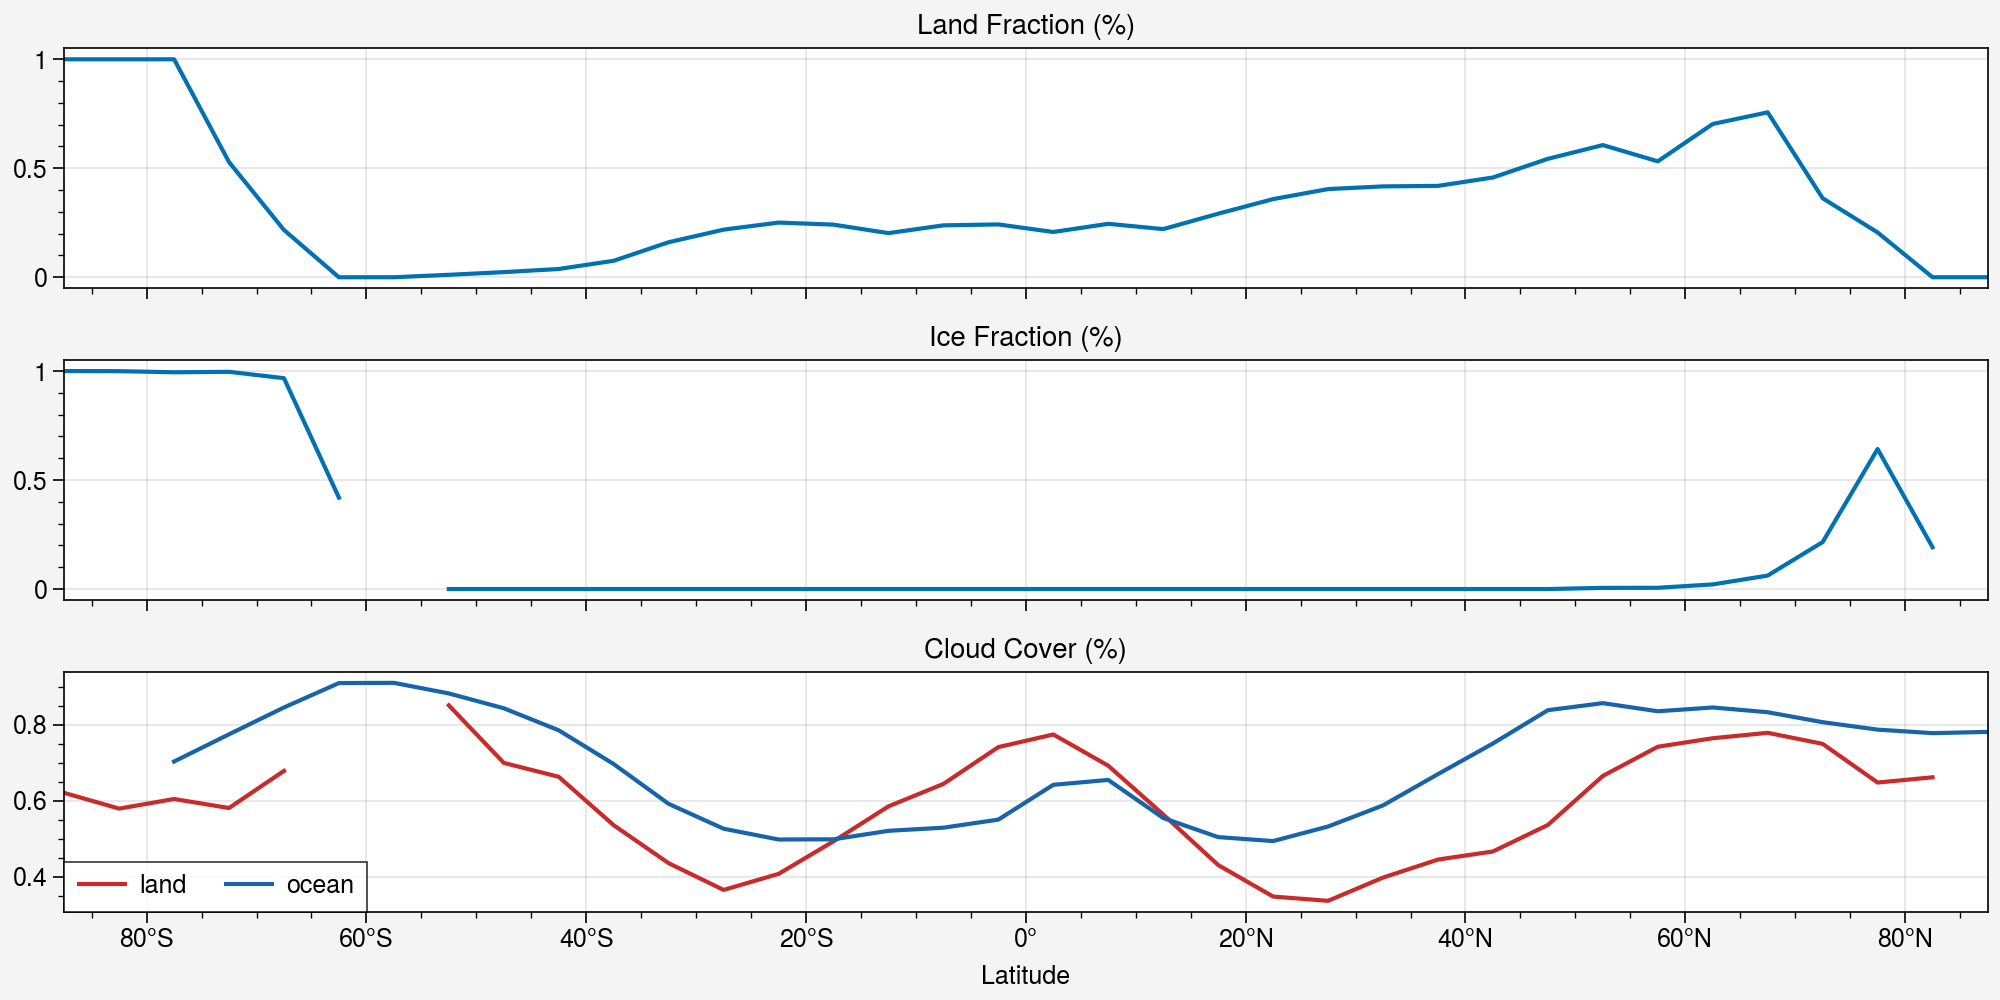

In [3]:
os.chdir(script_path)
from initialize_zemba import *
Var = get_constants(input_zemba) # load model constants

import proplot as pplt
fig, axs = pplt.subplots(nrows=3, ncols=1, figsize = (10,5))
axs[0].plot(Var['lat'], input_zemba['land_fraction'])
axs[1].plot(Var['lat'], input_zemba['ice_fraction'])
axs[2].plot(Var['lat'], input_zemba['ccl'], color = 'red9', label = ['land'])
axs[2].plot(Var['lat'], input_zemba['cco'], color = 'blue9', label = ['ocean'])
axs[2].legend()
axs[0].format(title = 'Land Fraction (%)')
axs[1].format(title = 'Ice Fraction (%)')
axs[2].format(title = 'Cloud Cover (%)')
axs.format(xlabel = 'Latitude', xformatter = 'deglat')

# Run the model..

Below I have loaded a template for running an equilibrium simulation of the model for 3000 yrs run. 

Note: The *input_list* variable specifies which input files (from the input folder) are run. In this case, we use the 'input_template.py' file shown above...


**THIS WILL TAKE A FEW MINUTES TO RUN**

In [4]:
os.chdir(script_path) # first change directory 

In [5]:
# %load equilirun_template.py
"""
@author: Daniel Gunning (University of Bergen)

Example template for running an equillibrium simulation of ZEMBA. 
"""

import numpy as np
from numba.core import types
from numba.typed import Dict
from numba import njit
import os
import sys
import pickle
import importlib
from time import process_time
from initialize_zemba import *
from zemba import *
from solar_forcing import *
from utilities import *

script_path = os.getcwd()
input_path  = script_path + '/input/'
output_path = script_path + '/output/'


#--------------------
# List of experiments [input files]
#--------------------

input_list = ['input_template']


#----------------------------------------------
# Run the model iteratively through experiments
#----------------------------------------------

for exp in input_list:
    
    # load input file
    #----------------
    os.chdir(input_path)
    file = importlib.import_module(exp)
    os.chdir(script_path)
    
    # load data from input file
    #--------------------------
    
    # run name
    name           = file.name 

    # input dictionary                
    input_zemba    = file.input_zemba   

    # settings dictionary           
    settings_zemba = file.settings_zemba   

    # version        
    version        = file.input_version   
             
    # fixed land albedo
    fixed_land_albedo  = file.fixed_land_albedo 

    # fixed ocean albedo   
    fixed_ocean_albedo = file.fixed_ocean_albedo       
                                    
    # fixed land snow
    fixed_snow_fraction = file.fixed_snow_fraction     
    fixed_snow_thick    = file.fixed_snow_thick
    fixed_snow_melt     = file.fixed_snow_melt
    
    # fix sea ice                                        
    fixed_si_fraction = file.fixed_si_fraction         
    fixed_si_thick    = file.fixed_si_thick
    fixed_si_melt     = file.fixed_si_melt
    
    # load constants
    #---------------
    
    Var = get_constants(input_zemba)
    
    # initialize model state
    #-----------------------
    
    State = initialize_state(Var, input_zemba)
    
    # insolation forcing
    #-------------------
    
    # load orbital parameters
    orb = import_orbital_parameters_v2( input_zemba['ikyr'][0] ) 

    # insolation forcing
    ecc, obl, pre, I, znth_sw, znth_dw = calculate_daily_insolation(orb, Var["latr"], Var["ndays"], day_type = 1)
    I = I * input_zemba['strength_of_insolation'] # modify strength (experimental)
    
    # Change ocean overturning strength
    #----------------------------------

    State["ww"] = State["ww"] * input_zemba['strength_of_overturning']
    
    # Key variables to save for every year
    #-------------------------------------
    
    # key_variables = ['Tlgx', 'Tosg', 'Tsgx', 'Tagx']
    key_variables = ['Tax']
    
    # Run the model
    #--------------

    t1_start = process_time() # start timer
    
    State, StateYear, StateAnnual = ebm(Var, State, input_zemba, I, znth_dw, settings_zemba, key_variables,
                                        
                                        # [option to fix albedo]
                                        fixed_land_albedo=fixed_land_albedo,
                                        fixed_ocean_albedo=fixed_ocean_albedo,
                                        
                                        # [option to fix snow over land]
                                        fixed_snow_fraction = fixed_snow_fraction,
                                        fixed_snow_thick    = fixed_snow_thick,
                                        fixed_snow_melt     = fixed_snow_melt,
                                        
                                        # [option to fix sea ice]
                                        fixed_si_fraction = fixed_si_fraction,
                                        fixed_si_thick    = fixed_si_thick,
                                        fixed_si_melt     = fixed_si_melt)
    
    t1_stop = process_time()  # end timer
    print("Elapsed time:", t1_stop - t1_start)
    
    # Save model data 
    #----------------
    
    # nested dict with all ouput
    zemba_output = {}
    zemba_output['Var']           = {}
    zemba_output['Settings']      = {}
    zemba_output['Input']         = {}
    zemba_output['State']         = {}
    zemba_output['StateYear']     = {}
    zemba_output['StateAnnual']   = {}
    
    
    for k,v in Var.items():
        zemba_output['Var'][k] = v
    for k,v in settings_zemba.items():
        zemba_output['Settings'][k] = v 
    for k,v in input_zemba.items():
        zemba_output['Input'][k] = v 
    for k,v in State.items():
        zemba_output['State'][k] = v 
    for k,v in StateYear.items():
        zemba_output['StateYear'][k] = v 
    for k,v in StateAnnual.items():
        zemba_output['StateAnnual'][k] = v 
    
    # save nested python dict
    with open('%soutput_%s_res%s.pkl' % (output_path, name, str(input_zemba['res'][0])), 'wb') as f:
            pickle.dump(dict(zemba_output), f)
   
    
    # delete input file
    #------------------
    del input_zemba
    del settings_zemba
    del name           
    del version
    del fixed_land_albedo 
    del fixed_ocean_albedo                                
    del fixed_snow_fraction 
    del fixed_snow_thick    
    del fixed_snow_melt                                           
    del fixed_si_fraction 
    del fixed_si_thick     
    del fixed_si_melt 
    del Var
    del State
    del StateYear
    del StateAnnual
    
    
   

Elapsed time: 199.0


# Load and Plot Model Output

The output from ZEMBA is saved in the 'output/' directory. It comprises a nested dictionary containing all the important ZEMBA dictionary such as Var, INPUT, State, StateYear, StateAnnual (described above...).

### Load the Model Output

In [6]:
os.chdir(output_path) # first change directory
with open('output_template_res5.0.pkl', 'rb') as f:
    zemba_output = pickle.load(f)
        
# load individual dictionaries within nested dictionary
Var = zemba_output['Var']
INPUT = zemba_output['Input']
State = zemba_output['State']
StateYear = zemba_output['StateYear']
StateAnnual = zemba_output['StateAnnual']

### Plot Model Output

Let's plot some variables for the final year of the model run, including the seasonal cycle and the annual mean...

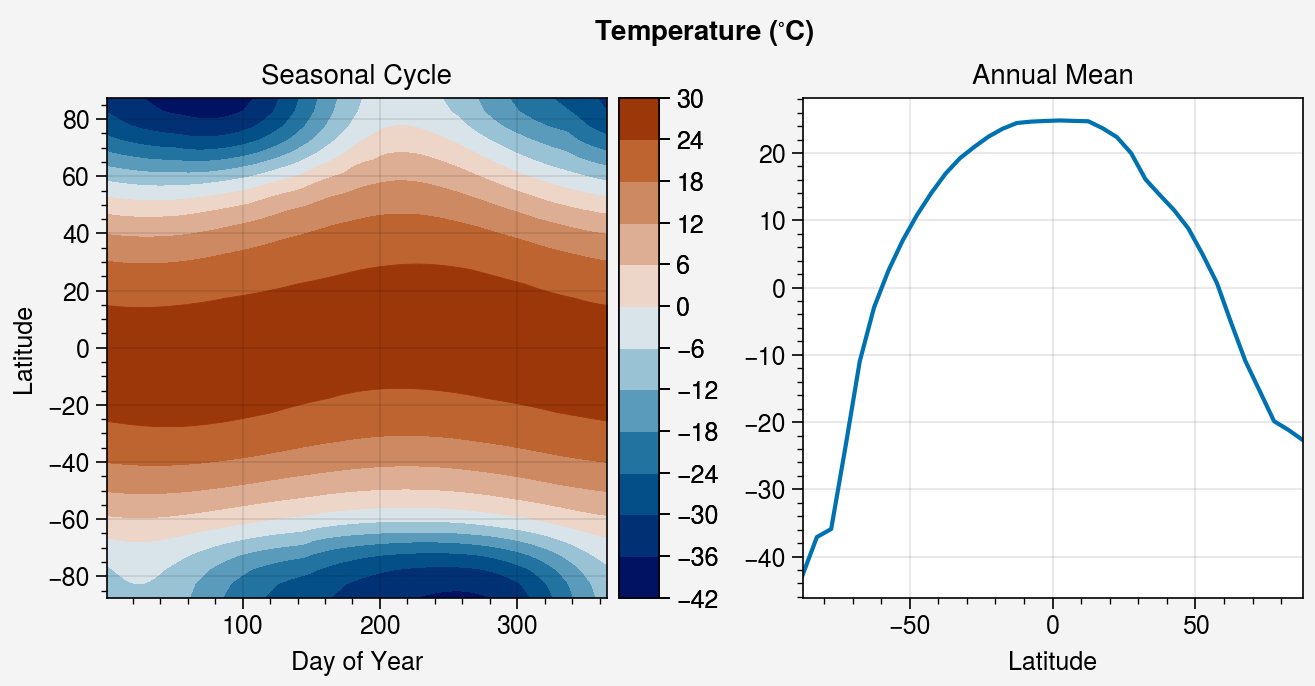

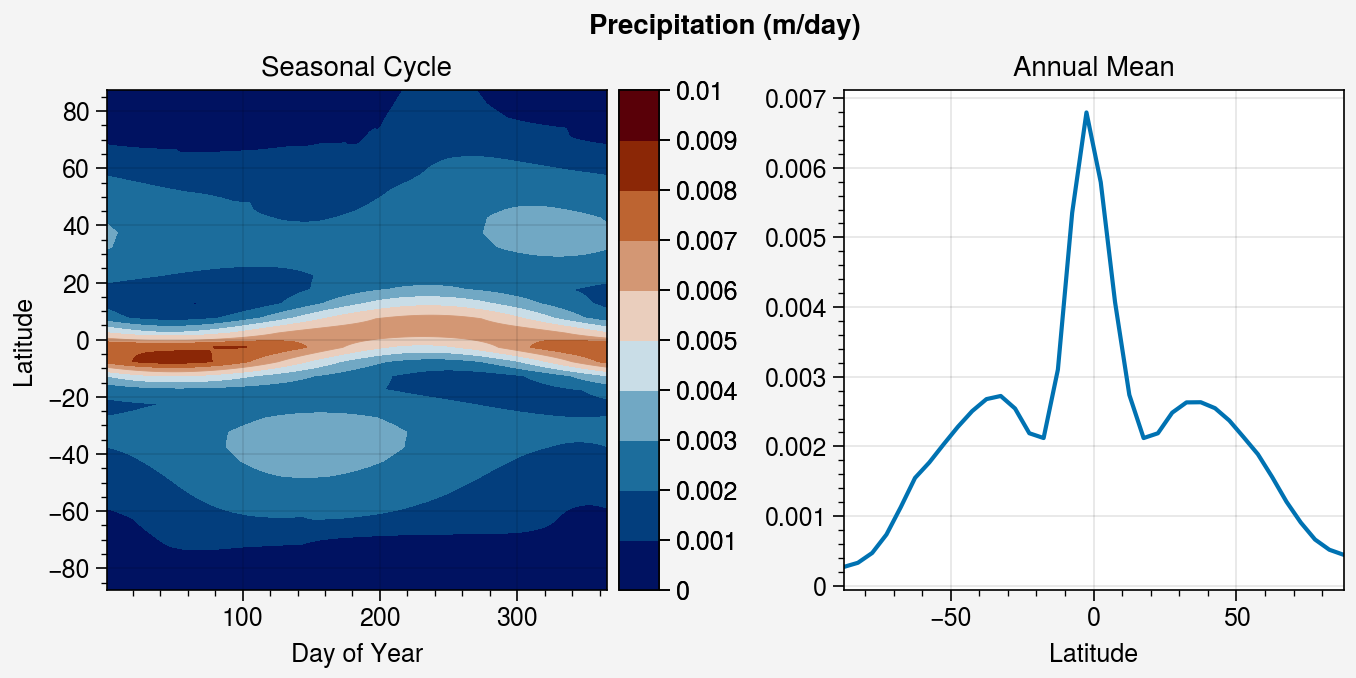

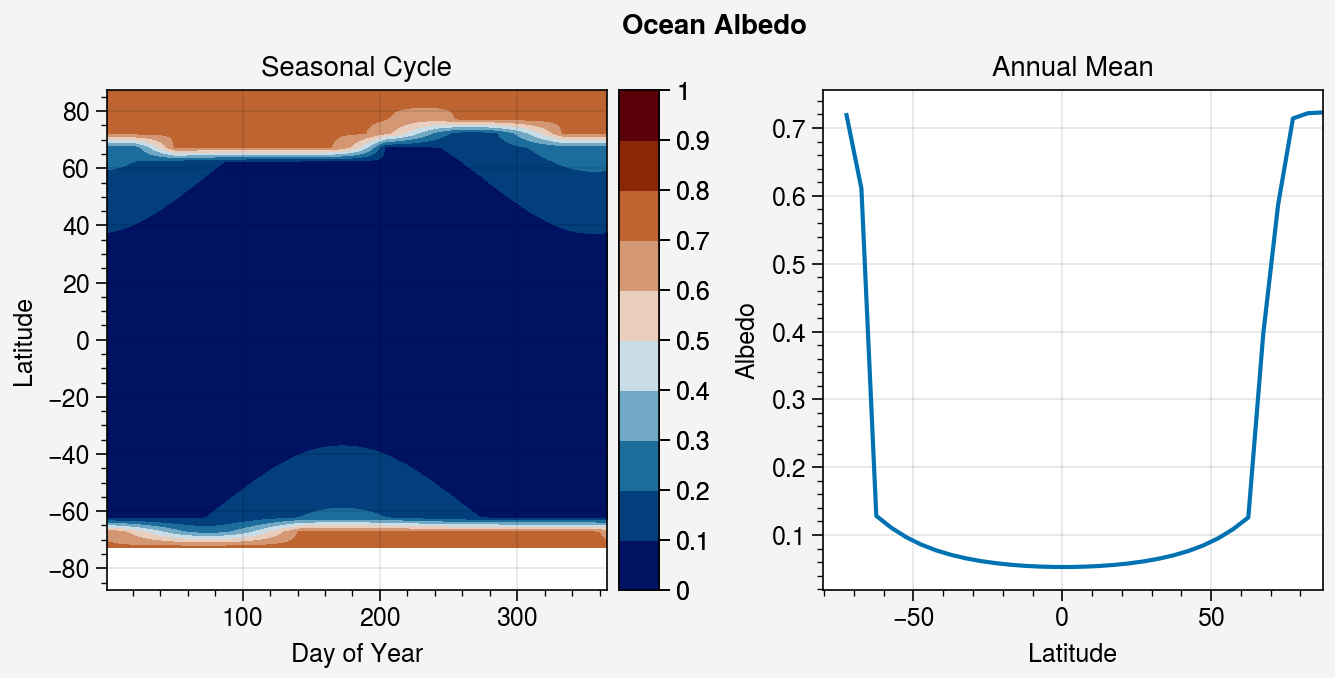

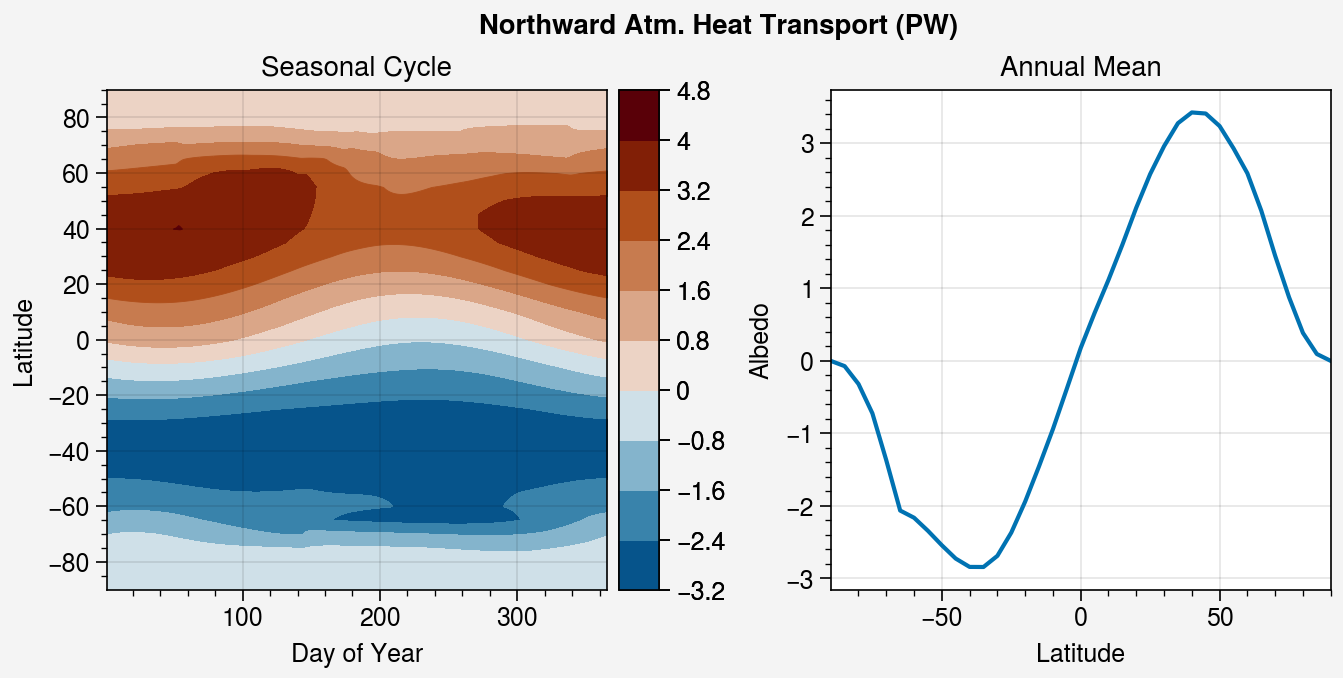

In [7]:
import proplot as pplt

# Temperature
fig, axs = pplt.subplots(ncols=2, nrows=1, sharex = False, sharey = False)
fig.suptitle(r'Temperature ($^{\circ}$C)')
# seasonal cycle
days, lat = np.meshgrid(Var["ndays"], Var["lat"])
axs[0,0].contourf(days, lat, StateYear['Ta']-273.15, colorbar = 'r', cmap = 'vik')
axs[0,0].format(xlabel = 'Day of Year', ylabel = 'Latitude', title = 'Seasonal Cycle')
# annual mean
axs[0,1].plot(Var['lat'], StateYear['Tax'].mean(axis=1)-273.15)
axs[0,1].format(xlabel = 'Latitude', title = 'Annual Mean')

# Precipitation
fig, axs = pplt.subplots(ncols=2, nrows=1, sharex = False, sharey = False)
fig.suptitle('Precipitation (m/day)')
# seasonal cycle
axs[0,0].contourf(days, lat, StateYear['precip_rate'], colorbar = 'r', vmin = 0, vmax = 0.01, levels = 10, cmap = 'vik')
axs[0,0].format(xlabel = 'Day of Year', ylabel = 'Latitude', title = 'Seasonal Cycle')
# annual mean
axs[0,1].plot(Var['lat'], StateYear['precip_rate'].mean(axis=1))
axs[0,1].format(xlabel = 'Latitude', title = 'Annual Mean')


# Surface Albedo
fig, axs = pplt.subplots(ncols=2, nrows=1, sharex = False, sharey = False)
fig.suptitle('Ocean Albedo')
alpha_surface = StateYear["alpha_ocean"]
# seasonal cycle
axs[0,0].contourf(days, lat, alpha_surface, colorbar = 'r', vmax = 1, cmap = 'vik')
axs[0,0].format(xlabel = 'Day of Year', ylabel = 'Latitude', title = 'Seasonal Cycle')
# annual mean
axs[0,1].plot(Var['lat'], np.nanmean(alpha_surface,axis=1))
axs[0,1].format(xlabel = 'Latitude', ylabel = r'Albedo', title = 'Annual Mean')


# Northward Atmospheric Heat Transport
fig, axs = pplt.subplots(ncols=2, nrows=1, sharex = False, sharey = False)
fig.suptitle('Northward Atm. Heat Transport (PW)')
# seasonal cycle
days, lat = np.meshgrid(Var["ndays"], Var["latb"])
axs[0,0].contourf(days, lat, StateYear['mse_north']/1e15, colorbar = 'r', cmap = 'vik')
axs[0,0].format(xlabel = 'Day of Year', ylabel = 'Latitude', title = 'Seasonal Cycle')
# annual mean
axs[0,1].plot(Var['latb'], StateYear['mse_north'].mean(axis=1)/1e15)
axs[0,1].format(xlabel = 'Latitude', ylabel = r'Albedo', title = 'Annual Mean')

### Plot Pre-Industrial Output

In the output folder, are some more detailed scripts for plotting pre-industrial output compared to state-of-the-art climate models and reanalysis data. Here, we can load a few of those scripts and see the output....

In [8]:
os.chdir(script_path+'/output/plots/') # first change directory 

###########################
Global Mean Air Temperature
###########################
ZEMBA: 13.87
NorESM2: 13.782313507687647
ERA5: 13.720849384048305



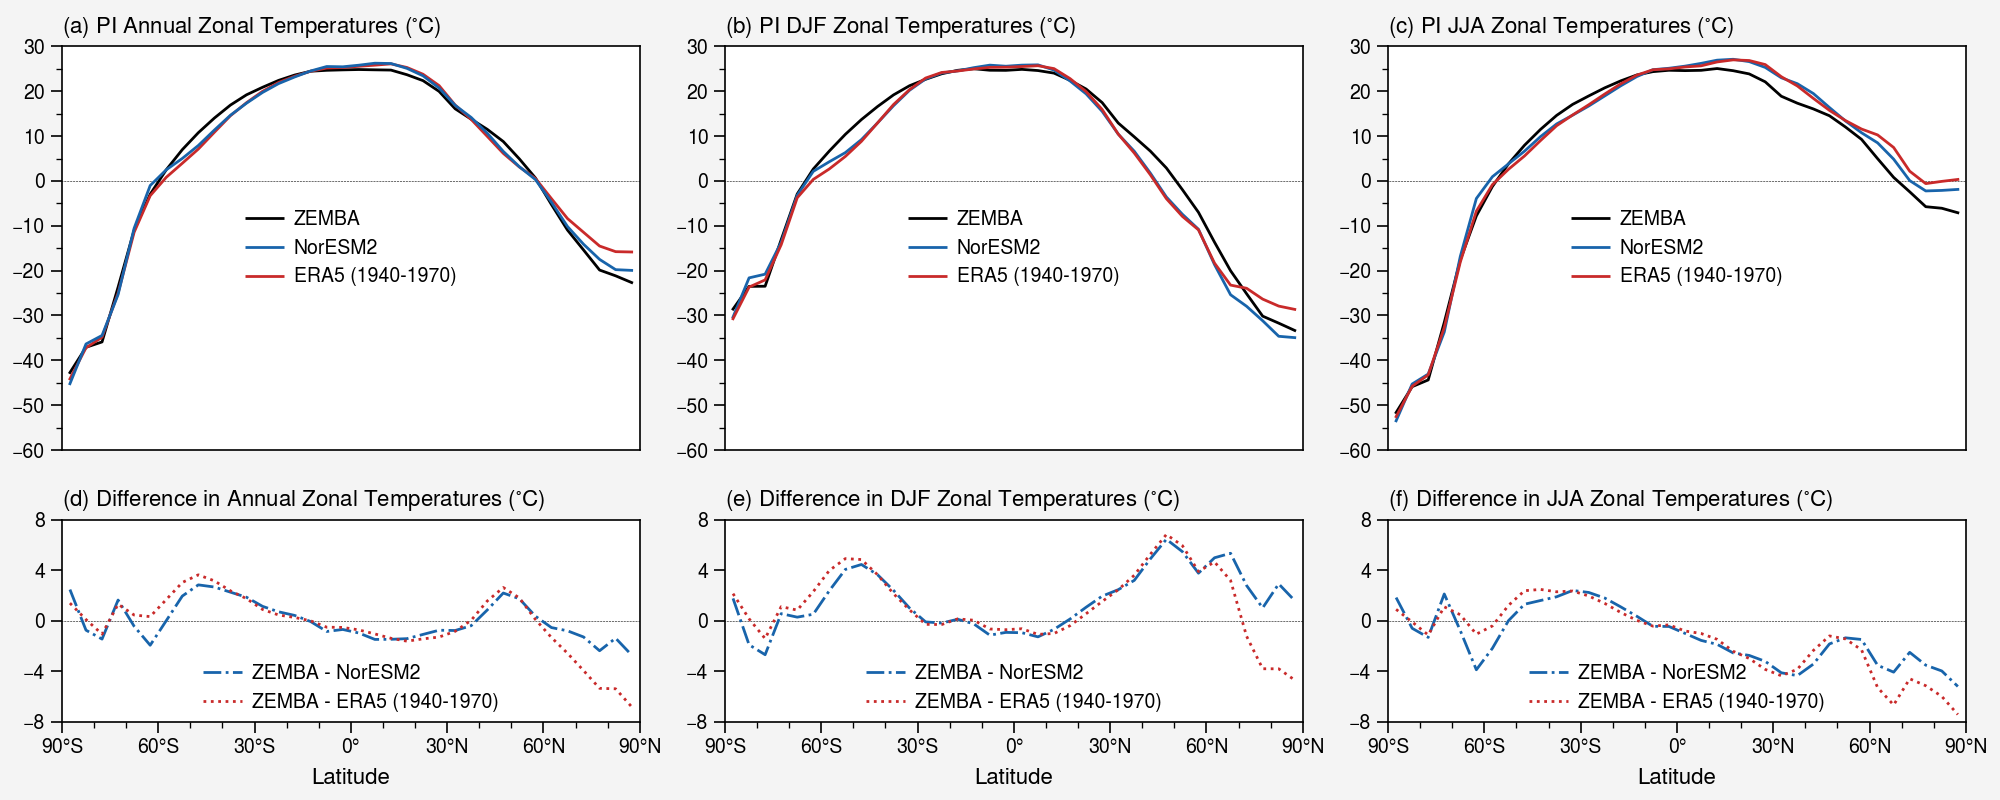

In [9]:
# %load plot_f02
"""
plot figure 2 - results section - pre-industrial air temperature

@author: Daniel Gunning 
"""

import numpy as np
import proplot as pplt
import os
import pickle
import xarray as xr

# path
output_path  = os.path.dirname(os.getcwd())
script_path  = os.path.dirname(output_path)
input_path   = script_path + '/input'

os.chdir(script_path)
from utilities import *

#------------------------------
# load zemba pre-industrial sim
#------------------------------

with open(output_path+'/output_equili_pi_res5.0.pkl', 'rb') as f:
    pi_sim = pickle.load(f)
    
# with open('output/equilibrium/pi_moist_res5.0.pkl', 'rb') as f:
#     pi_sim = pickle.load(f)
    
pi    = pi_sim['StateYear']
Var   = pi_sim['Var']
INPUT = pi_sim['Input']
     
# annual-mean surface air temperature
#------------------------------------

zemba_tas_annual = pi["Tax"].mean(axis=1) - Var["K"]
zemba_tas_global = round(global_pymean(zemba_tas_annual, Var), 2)

# june-july-august mean surface air temperature
#----------------------------------------------

zemba_tas_jja = pi["Tax"][:,151:242+1].mean(axis=1) - Var["K"] 

# december-january-february mean surface air temperature
#-------------------------------------------------------

zemba_tas_djf = ((np.append(pi["Tax"][:,0:58+1], pi["Tax"][:,334:], axis = 1)).mean(axis=1)) - Var["K"] 

#-----------------------------------
# load pre-industrial NorESM2 output
#-----------------------------------

# load data
noresm2_lat             = np.loadtxt(input_path+'/other_data/noresm2/noresm2_annual.txt', skiprows=5, usecols=0)
noresm2_tas_annual      = np.loadtxt(input_path+'/other_data/noresm2/noresm2_annual.txt', skiprows=5, usecols=1)
noresm2_tas_monthly_nc  = np.loadtxt(input_path+'/other_data/noresm2/noresm2_t2m_monthly.txt', skiprows=5, usecols=[1,2,3,4,5,6,7,8,9,10,11,12])

# interpolate data
noresm2_tas_annual  = np.interp(Var['lat'], noresm2_lat, noresm2_tas_annual) - Var['K']
noresm2_tas_monthly = np.zeros((Var['lat'].size, 12)) 
for i in np.arange(0,12):
    noresm2_tas_monthly[:,i]=np.interp(Var['lat'], noresm2_lat, noresm2_tas_monthly_nc[:,i])- Var['K']
    
# global_mean 
noresm2_tas_global = global_mean2(noresm2_tas_annual, Var["lat"], Var["dlat"])

# jja mean
noresm2_tas_jja = ( ((noresm2_tas_monthly[:,5]*30.) +
                    (noresm2_tas_monthly[:,6]*31.) +
                    (noresm2_tas_monthly[:,7]*31.))
            
                   /   
                   (30.+31.+31.) ) 

# djf mean
noresm2_tas_djf = ( ((noresm2_tas_monthly[:,11]*31.) +
                     (noresm2_tas_monthly[:,0]*31.) +
                     (noresm2_tas_monthly[:,1]*28.))
                   /
                   (31.+31.+28.) ) 

#-------------------------
# load era5 1940-1970 data
#-------------------------

# load data
era5_lat             = np.loadtxt(input_path+'/other_data/era5/era5_annual.txt', skiprows=5, usecols=0)
era5_tas_annual      = np.loadtxt(input_path+'/other_data/era5/era5_annual.txt', skiprows=5, usecols=1)
era5_tas_monthly_nc  = np.loadtxt(input_path+'/other_data/era5/era5_t2m_monthly.txt', skiprows=5, usecols=[1,2,3,4,5,6,7,8,9,10,11,12])

# interpolate data
era5_tas_annual  = np.interp(Var['lat'], era5_lat, era5_tas_annual) - Var['K']
era5_tas_monthly = np.zeros((Var['lat'].size, 12)) 
for i in np.arange(0,12):
    era5_tas_monthly[:,i]=np.interp(Var['lat'], era5_lat, era5_tas_monthly_nc[:,i]) - Var['K']
    
# global_mean 
era5_tas_global   = global_mean2(era5_tas_annual, Var["lat"], Var["dlat"])

# jja mean
era5_tas_jja = ( ((era5_tas_monthly[:,5]*30.) +
                 (era5_tas_monthly[:,6]*31.) +
                 (era5_tas_monthly[:,7]*31.))
                /
                (30.+31.+31.) ) 

# djf mean
era5_tas_djf = ( ((era5_tas_monthly[:,11]*31.) +
                 (era5_tas_monthly[:,0]*31.) +
                 (era5_tas_monthly[:,1]*28.))
                    /
                (31.+31.+28.) ) 

#---------
# plotting
#---------

# colors and line widths
#-----------------------

zemba_color = "black"
zemba_lw    = 1.
zemba_ls    = "-"

noresm_color = "blue9"
noresm_lw    = 1.
noresm_ls    = "-"

era5_color = "red9"
era5_lw    = 1.
era5_ls    = "-"

zemba_minus_noresm_color = "blue9"
zemba_minus_noresm_lw    = 1.
zemba_minus_noresm_ls    = "-."

zemba_minus_era5_color = "red9"
zemba_minus_era5_lw    = 1.
zemba_minus_era5_ls    = ":"

# legend font size
legend_fs = 7.
legend_fnt = "bold"

# formating
#----------

# shape
shape = [  
        [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6],
        [4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6],]

# figure and axes
fig, axs = pplt.subplots(shape, figsize = (10,4), sharey = False, sharex = False, grid = False)

# fonts
axs.format(ticklabelsize=7, ticklabelweight='normal', ylabelsize=8, ylabelweight='normal',
            xlabelsize=8, xlabelweight='normal', titlesize=8, titleweight='normal',)

# x-axis
axs.format(xlim = (-90, 90), xlocator = np.arange(-90, 120, 30), xminorlocator = np.arange(-90, 100, 10),)

# format top subplots
for i in np.arange(0,2+1):
    
    # y-axis
    axs[i].format(ylim = (-60, 30), yminorlocator=np.arange(-60, 30, 5), ylocator = np.arange(-60, 30+10, 10))
    
    # hline
    axs[i].axhline(0, Var["lat"].min(), Var["lat"].max(), color = "black", lw = 0.2, linestyle ="--")

    # x-axis
    axs[i].xaxis.set_ticklabels([])
    axs[i].xaxis.set_ticks_position('none')
    axs[i].xaxis.set_tick_params(labelbottom=False)
    
# format bottom subplots  
for i in np.arange(3,5+1):
    
    # y-axis
    axs[i].format(ylim = (-8, 8), yminorlocator=[], ylocator = np.arange(-8, 8+4, 4))
    
    # hline
    axs[i].axhline(0, Var["lat"].min(), Var["lat"].max(), color = "black", lw = 0.2, linestyle ="--")

    # x-axis
    axs[i].format(xlabel = "Latitude", xformatter='deglat')

# titles
axs[0].format(title = r'(a) PI Annual Zonal Temperatures ($^{\circ}$C)',titleloc = 'left')
axs[1].format(title = r'(b) PI DJF Zonal Temperatures ($^{\circ}$C)',titleloc = 'left')
axs[2].format(title = r'(c) PI JJA Zonal Temperatures ($^{\circ}$C)', titleloc = "left")
axs[3].format(title = r'(d) Difference in Annual Zonal Temperatures ($^{\circ}$C)', titleloc = "left")
axs[4].format(title = r'(e) Difference in DJF Zonal Temperatures ($^{\circ}$C)', titleloc = "left")
axs[5].format(title = r'(f) Difference in JJA Zonal Temperatures ($^{\circ}$C)', titleloc = "left")
 

# plot annual mean temperatures
#------------------------------

# lines
zemba_annual_line    = axs[0].plot(Var["lat"], zemba_tas_annual, color = zemba_color, lw = zemba_lw, linestyle = zemba_ls)
era5_annual_line   = axs[0].plot(Var["lat"], era5_tas_annual, color = era5_color, lw = era5_lw, linestyle = era5_ls)
noresm_annual_line = axs[0].plot(Var["lat"], noresm2_tas_annual, color = noresm_color, lw = noresm_lw, linestyle = noresm_ls)

# legends
axs[0].legend(handles = [zemba_annual_line, noresm_annual_line, era5_annual_line], labels = ["ZEMBA", "NorESM2", "ERA5 (1940-1970)"], ncols = 1, loc = "c", frameon = False, prop={'size':legend_fs})

# plot differences
zemba_minus_noresm_annual_line = axs[3].plot(Var["lat"], zemba_tas_annual - noresm2_tas_annual, color = zemba_minus_noresm_color, lw = zemba_minus_noresm_lw, linestyle = zemba_minus_noresm_ls)
zemba_minus_era5_annual_line   = axs[3].plot(Var["lat"], zemba_tas_annual - era5_tas_annual, color = zemba_minus_era5_color, lw = zemba_minus_era5_lw, linestyle = zemba_minus_era5_ls)

# difference legends
axs[3].legend(handles = [zemba_minus_noresm_annual_line, zemba_minus_era5_annual_line], labels = ["ZEMBA - NorESM2", "ZEMBA - ERA5 (1940-1970)"], ncols = 1, loc = "lc", frameon = False, prop={'size':legend_fs})

# plot december - january - february
#-----------------------------------

# lines
zemba_djf_line    = axs[1].plot(Var["lat"], zemba_tas_djf, color = zemba_color, lw = zemba_lw, linestyle = zemba_ls, alpha = 1)
noresm_djf_line = axs[1].plot(Var["lat"], noresm2_tas_djf, color = noresm_color, lw = noresm_lw, linestyle = noresm_ls, alpha = 1)
era5_djf_line   = axs[1].plot(Var["lat"], era5_tas_djf, color = era5_color, lw = era5_lw, linestyle = era5_ls, alpha = 1)
axs[1].legend(handles = [zemba_djf_line, noresm_djf_line, era5_djf_line], labels = ["ZEMBA", "NorESM2", "ERA5 (1940-1970)"], ncols = 1, loc = "c", frameon = False, prop={'size':legend_fs})

# plot difference
zemba_minus_noresm_djf_line = axs[4].plot(Var["lat"], zemba_tas_djf - noresm2_tas_djf, color = zemba_minus_noresm_color, lw = zemba_minus_noresm_lw, linestyle = zemba_minus_noresm_ls)
zemba_minus_era5_djf_line   = axs[4].plot(Var["lat"], zemba_tas_djf - era5_tas_djf, color = zemba_minus_era5_color, lw = zemba_minus_era5_lw, linestyle = zemba_minus_era5_ls)
axs[4].legend(handles = [zemba_minus_noresm_djf_line, zemba_minus_era5_djf_line, era5_annual_line], labels = ["ZEMBA - NorESM2", "ZEMBA - ERA5 (1940-1970)"], ncols = 1, loc = "lc", frameon = False, prop={'size':legend_fs})

# plot june - july - august
#--------------------------

# lines
zemba_jja_line    = axs[2].plot(Var["lat"], zemba_tas_jja, color = zemba_color, lw = zemba_lw, linestyle = zemba_ls, alpha = 1)
noresm_jja_line = axs[2].plot(Var["lat"], noresm2_tas_jja, color = noresm_color, lw = noresm_lw, linestyle = noresm_ls, alpha = 1)
era5_jja_line   = axs[2].plot(Var["lat"], era5_tas_jja, color = era5_color, lw = era5_lw, linestyle = era5_ls, alpha = 1)
axs[2].legend(handles = [zemba_jja_line, noresm_jja_line, era5_jja_line], labels = ["ZEMBA", "NorESM2", "ERA5 (1940-1970)"], ncols = 1, loc = "c", frameon = False, prop={'size':legend_fs})

# plot difference
zemba_minus_noresm_jja_line = axs[5].plot(Var["lat"], zemba_tas_jja - noresm2_tas_jja, color = zemba_minus_noresm_color, lw = zemba_minus_noresm_lw, linestyle = zemba_minus_noresm_ls)
zemba_minus_era5_jja_line   = axs[5].plot(Var["lat"], zemba_tas_jja - era5_tas_jja, color = zemba_minus_era5_color, lw = zemba_minus_era5_lw, linestyle = zemba_minus_era5_ls)
leg = axs[5].legend(handles = [zemba_minus_noresm_jja_line, zemba_minus_era5_jja_line, era5_annual_line], labels = ["ZEMBA - NorESM2", "ZEMBA - ERA5 (1940-1970)"], ncols = 1, loc = "lc", frameon = False, prop={'size':legend_fs})

fig.save(os.getcwd()+"/output/plots/f02.png", dpi= 300)
fig.save(os.getcwd()+"/output/plots/f02.pdf", dpi= 300)

#------------------------------------------------------------------------------
# Print global mean air temperatures
#------------------------------------------------------------------------------

print('###########################')
print('Global Mean Air Temperature')
print('###########################')   
print("ZEMBA: " + str(zemba_tas_global))
print("NorESM2: " + str(noresm2_tas_global))
print("ERA5: " + str(era5_tas_global) + '\n')

In [10]:
os.chdir(script_path+'/output/plots/') # first change directory 

###########################
Global Mean Precipitation....
###########################
Zemba: 2.77
NorESM2: 2.85
ERA5: 2.86

###########################
Global Mean Evaporation....
###########################
Zemba: 2.77
NorESM2: 2.85
ERA5: 2.8

###########################
Global Mean Snowfall....
###########################
pyzemba: 0.14
NorESM2: 0.21
ERA5: 0.22



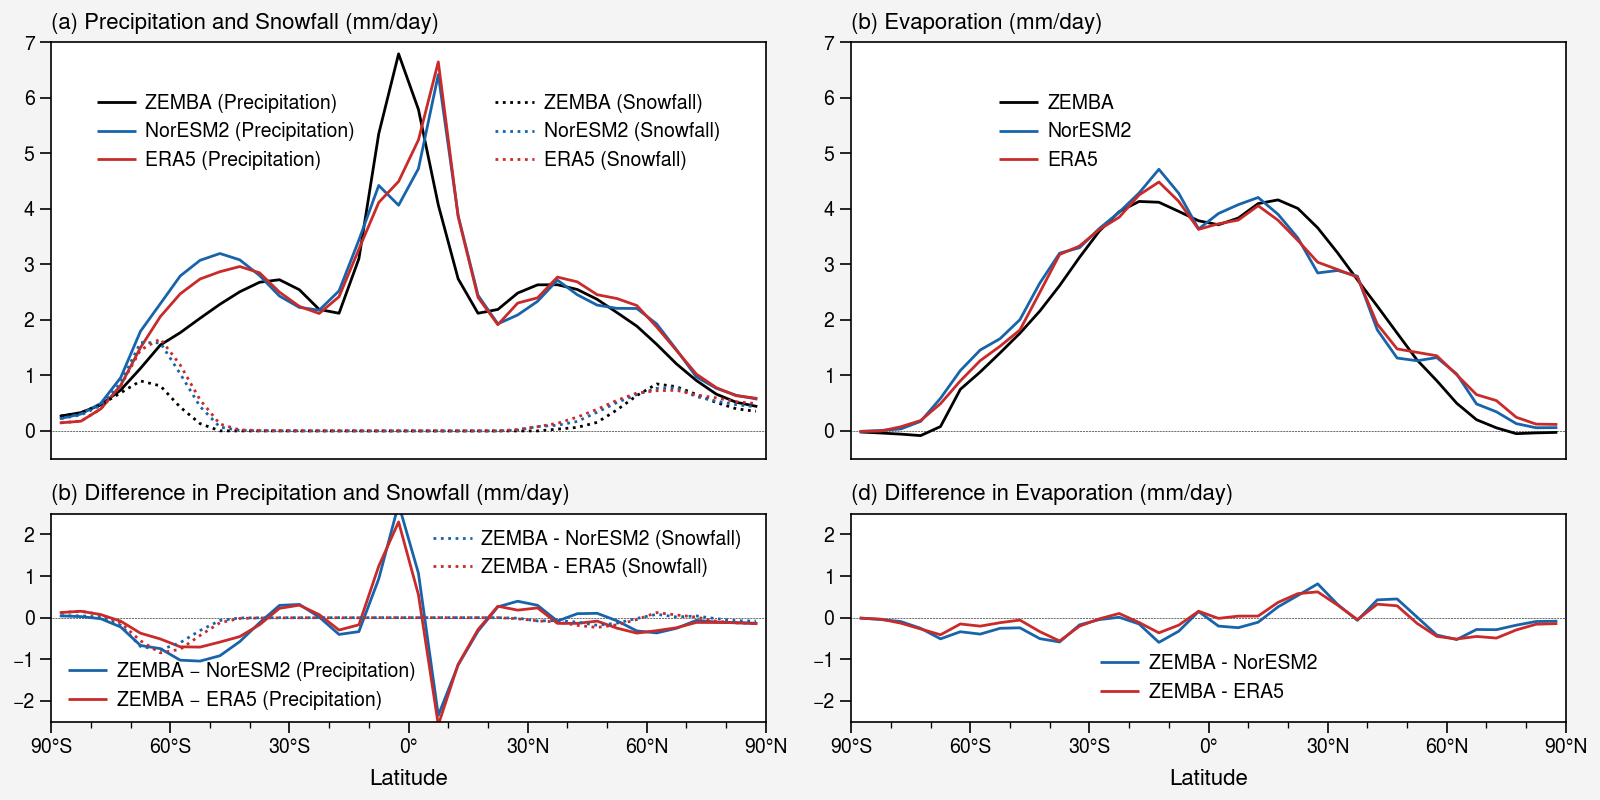

In [11]:
# %load plot_f03
"""
plot figure 3 - results section - pre-industrial precipitation, snowfall, evaporation

@author: Daniel Gunning 
"""

import numpy as np
import proplot as pplt
import os
import pickle
import xarray as xr

# paths
output_path  = os.path.dirname(os.getcwd())
script_path  = os.path.dirname(output_path)
input_path   = script_path + '/input'

os.chdir(script_path)
from utilities import *

#------------------------------
# load zemba pre-industrial sim
#------------------------------

# load data
with open(output_path+'/output_equili_pi_res5.0.pkl', 'rb') as f:
    pi_sim = pickle.load(f)
    
pi    = pi_sim['StateYear']
Var   = pi_sim['Var']
INPUT = pi_sim['Input']
    
# precipitation
zemba_precip        = (pi['precip_flux'].mean(axis=1)/1000)*(60*60*24)*1000 
zemba_precip_global = global_mean2(zemba_precip, Var["lat"], Var["dlat"])

# snowfall
zemba_sf        = (pi['snowfall_flux'].mean(axis=1)/1000)*(60*60*24)*1000  
zemba_sf_global = global_mean2(zemba_sf, Var["lat"], Var["dlat"])

# evaporation
zemba_evap        = (pi['evap_flux'].mean(axis=1)/1000)*(60*60*24)*1000
zemba_evap_global = global_mean2(zemba_evap, Var["lat"], Var["dlat"])

#-----------------------------------
# load pre-industrial NorESM2 output
#-----------------------------------

# load annual data
noresm2_lat      = np.loadtxt(input_path+'/other_data/noresm2/noresm2_annual.txt', skiprows=5, usecols=0)
noresm2_precip   = np.loadtxt(input_path+'/other_data/noresm2/noresm2_annual.txt', skiprows=5, usecols=2)
noresm2_sf       = np.loadtxt(input_path+'/other_data/noresm2/noresm2_annual.txt', skiprows=5, usecols=3)
noresm2_evap     = np.loadtxt(input_path+'/other_data/noresm2/noresm2_annual.txt', skiprows=5, usecols=4)

# interpolate data
noresm2_precip   = np.interp(Var['lat'], noresm2_lat, noresm2_precip)
noresm2_sf       = np.interp(Var['lat'], noresm2_lat, noresm2_sf)
noresm2_evap     = np.interp(Var['lat'], noresm2_lat, noresm2_evap)

# change from kg m-2 s-1 to mm day-1
noresm2_precip   = noresm2_precip * 1000 * (60*60*24) / 1000
noresm2_sf       = noresm2_sf * 1000 * (60*60*24) / 1000
noresm2_evap     = noresm2_evap * 1000 * (60*60*24) / 1000

# global_mean 
noresm2_precip_global   = global_mean2(noresm2_precip, Var["lat"], Var["dlat"])
noresm2_sf_global       = global_mean2(noresm2_sf, Var["lat"], Var["dlat"])
noresm2_evap_global     = global_mean2(noresm2_evap, Var["lat"], Var["dlat"])


#---------------------------
# ERA5 1940-1970 climatology
#---------------------------

# load annual data
era5_lat      = np.loadtxt(input_path+'/other_data/era5/era5_annual.txt', skiprows=5, usecols=0)
era5_precip   = np.loadtxt(input_path+'/other_data/era5/era5_annual.txt', skiprows=5, usecols=2)
era5_sf       = np.loadtxt(input_path+'/other_data/era5/era5_annual.txt', skiprows=5, usecols=3)
era5_evap     = np.loadtxt(input_path+'/other_data/era5/era5_annual.txt', skiprows=5, usecols=4)

# interpolate data
era5_precip   = np.interp(Var['lat'], era5_lat, era5_precip)
era5_sf       = np.interp(Var['lat'], era5_lat, era5_sf)
era5_evap     = -np.interp(Var['lat'], era5_lat, era5_evap)

# change from kg m-2 s-1 to mm day-1
era5_precip   = era5_precip * 1000 * (60*60*24) / 1000
era5_sf       = era5_sf * 1000 * (60*60*24) / 1000
era5_evap     = era5_evap * 1000 * (60*60*24) / 1000

# global_mean 
era5_precip_global   = global_mean2(era5_precip, Var["lat"], Var["dlat"])
era5_sf_global       = global_mean2(era5_sf, Var["lat"], Var["dlat"])
era5_evap_global     = global_mean2(era5_evap, Var["lat"], Var["dlat"])

#---------
# plotting
#---------

# colors and line widths
#-----------------------

zemba_color = "black"
zemba_lw    = 1.
zemba_ls    = "-"

noresm2_color = "blue9"
noresm2_lw    = 1.
noresm2_ls    = "-"

era5_color = "red9"
era5_lw    = 1.
era5_ls    = "-"

zemba_minus_noresm2_color = "blue9"
zemba_minus_noresm2_lw    = 1.
zemba_minus_noresm2_ls    = "-."

zemba_minus_era5_color = "red9"
zemba_minus_era5_lw    = 1.
zemba_minus_era5_ls    = ":"

legend_fs = 7.

# formating
#----------

# shape
shape = [  
        [1, 1, 1, 1, 2, 2, 2, 2],
        [1, 1, 1, 1, 2, 2, 2, 2],
        [1, 1, 1, 1, 2, 2, 2, 2],
        [1, 1, 1, 1, 2, 2, 2, 2],
        [3, 3, 3, 3, 4, 4, 4, 4],
        [3, 3, 3, 3, 4, 4, 4, 4],]

# figure and axes
fig, axs = pplt.subplots(shape, figsize = (8,4), sharey = False, sharex = False, grid = False)

# fonts
axs.format(ticklabelsize=7, ticklabelweight='normal', ylabelsize=8, ylabelweight='normal',
           xlabelsize=8, xlabelweight='normal', titlesize=8, titleweight='normal',)

# x-axis
locatorx      = np.arange(-90, 120, 30)
minorlocatorx = np.arange(-90, 100, 10)
axs.format(xminorlocator = minorlocatorx, xlocator = locatorx, xlim = (-90, 90))

# format top left subplot
for i in np.arange(0,1):
    
    # y-axis
    axs[i].format(ylim = (-0.5, 7), yminorlocator=[], ylocator = np.arange(0, 7+1, 1))
    
    # hline
    axs[i].axhline(0, Var["lat"].min(), Var["lat"].max(), color = "black", lw = 0.2, linestyle ="--")
    
    # axis
    axs[i].xaxis.set_ticklabels([])
    axs[i].xaxis.set_ticks_position('none')
    axs[i].xaxis.set_tick_params(labelbottom=False)

# format top right subplot
for i in np.arange(1,2):
    
    # y-axis
    axs[i].format(ylim = (-0.5, 7), yminorlocator=[], ylocator = np.arange(0, 7+1, 1))
    
    # hline
    axs[i].axhline(0, Var["lat"].min(), Var["lat"].max(), color = "black", lw = 0.2, linestyle ="--")
    
    # axis
    axs[i].xaxis.set_ticklabels([])
    axs[i].xaxis.set_ticks_position('none')
    axs[i].xaxis.set_tick_params(labelbottom=False)
    
    
# format bottom subplots
for i in np.arange(2,3+1):
    
    # y-axis
    axs[i].format(ylim = (-2.5, 2.5), yminorlocator=[], ylocator = np.arange(-2, 2+1, 1))
    
    # hline
    axs[i].axhline(0, Var["lat"].min(), Var["lat"].max(), color = "black", lw = 0.2, linestyle ="--")
    
    # x-axis
    axs[i].format(xlabel = "Latitude", xformatter='deglat')    

# titles
axs[0].format(title = r'(a) Precipitation and Snowfall (mm/day)', titleloc = 'left')
axs[1].format(title = r'(b) Evaporation (mm/day)', titleloc = 'left')
axs[2].format(title = r'(b) Difference in Precipitation and Snowfall (mm/day)', titleloc = 'left')
axs[3].format(title = r'(d) Difference in Evaporation (mm/day)', titleloc = 'left')

# plot precipitation
#-------------------
zemba_precip_line = axs[0].plot(Var["lat"], zemba_precip, color = zemba_color, lw = zemba_lw, linestyle = zemba_ls)
noresm2_precip_line = axs[0].plot(Var["lat"], noresm2_precip, color = noresm2_color, lw = noresm2_lw, linestyle = noresm2_ls)
era5_precip_line = axs[0].plot(Var["lat"], era5_precip, color = era5_color, lw = era5_lw, linestyle = era5_ls)
axs[0].legend(handles = [zemba_precip_line, noresm2_precip_line, era5_precip_line],
              labels  = ["ZEMBA (Precipitation)", "NorESM2 (Precipitation)", "ERA5 (Precipitation)"], frameon = False, loc = "ul",
              bbox_to_anchor=(0.05, 0.9), ncols = 1, prop={'size':legend_fs})

# plot differences in precipitation
zemba_minus_noresm_precip = axs[2].plot(Var["lat"], zemba_precip - noresm2_precip, color = zemba_minus_noresm2_color, lw = zemba_minus_noresm2_lw, linestyle = "-")
zemba_minus_era5_precip   = axs[2].plot(Var["lat"], zemba_precip - era5_precip, color = zemba_minus_era5_color, lw = zemba_minus_era5_lw, linestyle = "-")
axs[2].legend(handles = [zemba_minus_noresm_precip, zemba_minus_era5_precip],
              labels  = ["ZEMBA − NorESM2 (Precipitation)", "ZEMBA − ERA5 (Precipitation) "], frameon = False,  loc = "ll",
               bbox_to_anchor=(0.01, 0.01), ncols = 1, prop={'size':legend_fs})



# plot snowfall
#--------------
zemba_sf_line = axs[0].plot(Var["lat"], zemba_sf, color = zemba_color, lw = zemba_lw, linestyle = ":", label = ["EBCM"])
noresm2_sf_line = axs[0].plot(Var["lat"], noresm2_sf, color = noresm2_color, lw = noresm2_lw, linestyle = ":", label = ["noresm"])
era5_sf_line = axs[0].plot(Var["lat"], era5_sf, color = era5_color, lw = era5_lw, linestyle = ":", label = ["ERA5 (1940-1970)"])
axs[0].legend(handles = [zemba_sf_line, noresm2_sf_line, era5_sf_line],
              labels  = ["ZEMBA (Snowfall)", "NorESM2 (Snowfall)", "ERA5 (Snowfall)"], frameon = False, loc = "ur",
              bbox_to_anchor=(0.95, 0.9), ncols = 1, prop={'size':legend_fs})

# plot differences in snowfall
zemba_minus_noresm_sf = axs[2].plot(Var["lat"], zemba_sf - noresm2_sf, color = zemba_minus_noresm2_color, lw = zemba_minus_noresm2_lw, linestyle = ":")
zemba_minus_era5_sf   = axs[2].plot(Var["lat"], zemba_sf - era5_sf, color = zemba_minus_era5_color, lw = zemba_minus_era5_lw, linestyle = ":")
axs[2].legend(handles = [zemba_minus_noresm_sf, zemba_minus_era5_sf],
              labels  = ["ZEMBA - NorESM2 (Snowfall)", "ZEMBA - ERA5 (Snowfall)"], frameon = False,  loc = "ur",
               bbox_to_anchor=(0.98, 0.97), ncols = 1, prop={'size':legend_fs})

# plot evaporation
#------------------
zemba_evap_line = axs[1].plot(Var["lat"], zemba_evap, color = zemba_color, lw = zemba_lw, linestyle = zemba_ls, label = ["EBCM"])
noresm2_evap_line = axs[1].plot(Var["lat"], noresm2_evap, color = noresm2_color, lw = noresm2_lw, linestyle = noresm2_ls, label = ["noresm"])
era5_evap_line = axs[1].plot(Var["lat"], era5_evap, color = era5_color, lw = era5_lw, linestyle = era5_ls, label = ["ERA5 (1940-1970)"])
axs[1].legend(handles = [zemba_evap_line, noresm2_evap_line, era5_evap_line],
              labels  = ["ZEMBA", "NorESM2", "ERA5"], frameon = False, loc = "uc",
              bbox_to_anchor=(0.3, 0.9), ncols = 1, prop={'size':legend_fs})

# plot differences in evaporation
zemba_minus_noresm_evap = axs[3].plot(Var["lat"], zemba_evap - noresm2_evap, color = zemba_minus_noresm2_color, lw = zemba_minus_noresm2_lw, linestyle = "-")
zemba_minus_era5_evap = axs[3].plot(Var["lat"], zemba_evap - era5_evap, color = zemba_minus_era5_color, lw = zemba_minus_era5_lw, linestyle = "-")
axs[3].legend(handles = [zemba_minus_noresm_evap, zemba_minus_era5_evap],
              labels  = ["ZEMBA - NorESM2", "ZEMBA - ERA5"], frameon = False,  loc = "lc",
               bbox_to_anchor=(0.5, 0.05), ncols = 1, prop={'size':legend_fs})

            
fig.save(os.getcwd()+"/output/plots/f03.png", dpi= 300)
fig.save(os.getcwd()+"/output/plots/f03.pdf", dpi= 300)


print('###########################')
print("Global Mean Precipitation....")
print('###########################')

print("Zemba: " + str(round(zemba_precip_global, 2)))

print("NorESM2: " + str(round(noresm2_precip_global, 2)))

print("ERA5: " + str(round(era5_precip_global, 2))+'\n')

print('###########################')
print("Global Mean Evaporation....")
print('###########################')

print("Zemba: " + str(round(zemba_evap_global, 2)))

print("NorESM2: " + str(round(noresm2_evap_global, 2)))

print("ERA5: " + str(round(era5_evap_global, 2))+'\n')

print('###########################')
print("Global Mean Snowfall....")
print('###########################')

print("pyzemba: " + str(round(zemba_sf_global, 2)))

print("NorESM2: " + str(round(noresm2_sf_global, 2)))

print("ERA5: " + str(round(era5_sf_global, 2))+'\n')


